# Fraud Detection & Monitoring (PaySim)

**Goal:** Build a baseline fraud model and choose an alert threshold that fits a realistic review capacity.  

**Dataset:** PaySim synthetic mobile money transactions. 

**Target:** `isFraud`.



## 1) Load data & quick sanity check

We load the PaySim transactions dataset, then run a quick sanity check:
- dataset shape
- first rows (head)
- column types (dtypes)


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

df = pd.read_csv("../data/paysim.csv")

print("Shape:", df.shape)
display(df.head())
display(df.dtypes)


Shape: (6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

## Sanity checks

Quick checks to confirm the dataset loaded correctly and the target distribution looks plausible before splitting and modeling.


In [2]:
# Sanity checks: target distribution + basic quality checks

TARGET = "isFraud"
FLAG = "isFlaggedFraud"

print("Rows, Cols:", df.shape)
print("Columns:", list(df.columns))

# Missing values (top 10)
na = df.isna().mean().sort_values(ascending=False)
print("\nMissing rate (top 10):")
display((na * 100).head(10).to_frame("missing_%"))

# Target rates
fraud_rate = df[TARGET].mean()
flag_rate  = df[FLAG].mean() if FLAG in df.columns else None

print(f"\nFraud rate:  {fraud_rate:.6f} ({fraud_rate*100:.4f}%)")
if flag_rate is not None:
    print(f"Flag rate:   {flag_rate:.6f} ({flag_rate*100:.4f}%)")

print("\nTarget counts:")
display(df[TARGET].value_counts(dropna=False).to_frame("count"))

if FLAG in df.columns:
    print("\nFlag counts:")
    display(df[FLAG].value_counts(dropna=False).to_frame("count"))

# Quick numeric sanity (amount should be >= 0)
if "amount" in df.columns:
    print("\nAmount sanity:")
    print("min amount:", df["amount"].min(), " | max amount:", df["amount"].max())


Rows, Cols: (6362620, 11)
Columns: ['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']

Missing rate (top 10):


,missing_%
step,0.0
type,0.0
amount,0.0
nameOrig,0.0
oldbalanceOrg,0.0
newbalanceOrig,0.0
nameDest,0.0
oldbalanceDest,0.0
newbalanceDest,0.0
isFraud,0.0



Fraud rate:  0.001291 (0.1291%)
Flag rate:   0.000003 (0.0003%)

Target counts:


,count
isFraud,
0,6354407
1,8213



Flag counts:


,count
isFlaggedFraud,
0,6362604
1,16



Amount sanity:
min amount: 0.0  | max amount: 92445516.64


**Next:** quantify class imbalance (fraud vs. non-fraud) and identify which transaction types concentrate most fraud.


## 2) Base rates (class imbalance)

Fraud is rare in PaySim. We compute the overall fraud rate (`isFraud`) and the flagged-fraud rate (`isFlaggedFraud`) to quantify class imbalance and set realistic expectations for precision/recall.


In [3]:
fraud_rate = df["isFraud"].mean()
flag_rate = df["isFlaggedFraud"].mean()

print(f"Fraud rate: {fraud_rate:.6f} ({fraud_rate*100:.4f}%)")
print(f"Flagged fraud rate: {flag_rate:.6f} ({flag_rate*100:.4f}%)")

df["isFraud"].value_counts()


Fraud rate: 0.001291 (0.1291%)
Flagged fraud rate: 0.000003 (0.0003%)


isFraud
0    6354407
1       8213
Name: count, dtype: int64

## Class imbalance (fraud prevalence)

Before modeling, we quantify how rare fraud is in this dataset.  
This matters because accuracy becomes misleading and we must evaluate with ROC-AUC / PR-AUC and pick thresholds based on review capacity.


In [4]:
fraud_by_type = (
    df.groupby("type")["isFraud"]
      .agg(count="count", frauds="sum", fraud_rate="mean")
      .sort_values("fraud_rate", ascending=False)
)
display(fraud_by_type)


,count,frauds,fraud_rate
type,,,
TRANSFER,532909,4097,0.007688
CASH_OUT,2237500,4116,0.001840
CASH_IN,1399284,0,0.000000
DEBIT,41432,0,0.000000
PAYMENT,2151495,0,0.000000


**Key takeaway:** Fraud is a rare event (~0.13%), and *flagged fraud* is even rarer.  
This confirms a highly imbalanced classification setting → we focus on PR-AUC and threshold-based alert policies rather than accuracy.


## 3) Quick visuals

We create three lightweight EDA plots and save them to `reports/figures/`:
- fraud rate by transaction type
- amount distribution (fraud vs non-fraud, log counts)
- fraud rate over time (`step`)


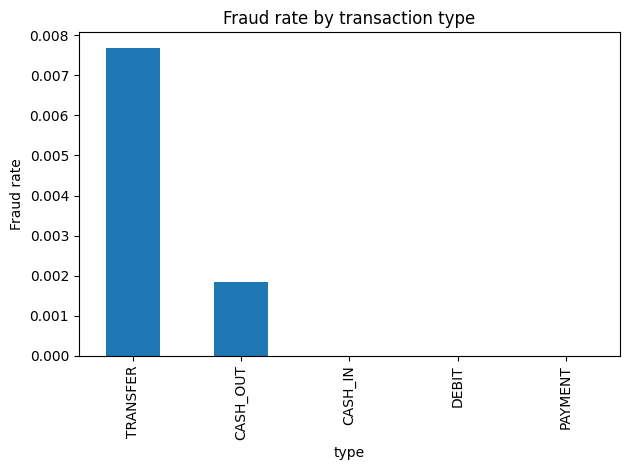

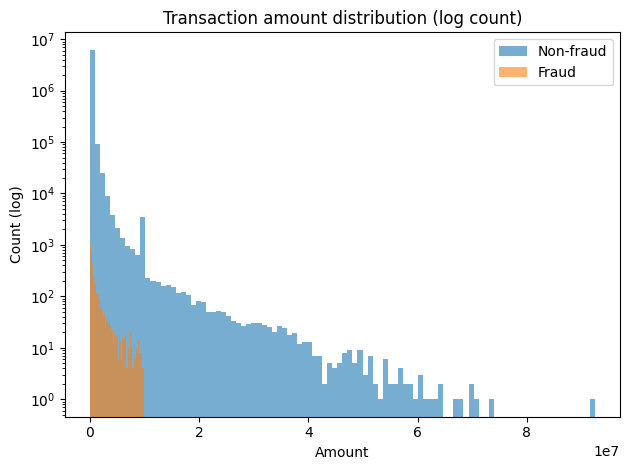

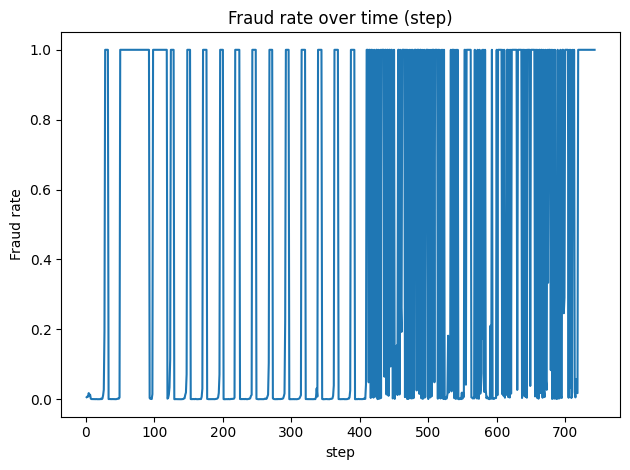

In [5]:
Path("../reports/figures").mkdir(parents=True, exist_ok=True)

# Plot 1: Fraud rate by type
plt.figure()
fraud_by_type["fraud_rate"].plot(kind="bar")
plt.title("Fraud rate by transaction type")
plt.ylabel("Fraud rate")
plt.tight_layout()
plt.savefig("../reports/figures/fraud_rate_by_type.png", dpi=150)
plt.show()
plt.close()

# Plot 2: Amount distribution fraud vs non-fraud (log counts)
plt.figure()
non = df.loc[df["isFraud"] == 0, "amount"]
frd = df.loc[df["isFraud"] == 1, "amount"]

plt.hist(non, bins=100, alpha=0.6, label="Non-fraud")
plt.hist(frd, bins=100, alpha=0.6, label="Fraud")
plt.yscale("log")
plt.title("Transaction amount distribution (log count)")
plt.xlabel("Amount")
plt.ylabel("Count (log)")
plt.legend()
plt.tight_layout()
plt.savefig("../reports/figures/amount_dist_fraud_vs_nonfraud.png", dpi=150)
plt.show()
plt.close()

# Plot 3: Fraud rate over time (step)
plt.figure()
fraud_over_time = df.groupby("step")["isFraud"].mean()
fraud_over_time.plot()
plt.title("Fraud rate over time (step)")
plt.ylabel("Fraud rate")
plt.tight_layout()
plt.savefig("../reports/figures/fraud_rate_over_time.png", dpi=150)
plt.show()
plt.close()


**Key takeaway:** Fraud concentrates in specific transaction types (especially **TRANSFER** and **CASH_OUT**).  
Amounts are heavily skewed, so log-scaled counts help compare fraud vs non-fraud.  
Fraud rate over time can fluctuate, which motivates a **time-based split** and monitoring.


## 4) Balance features sanity check

We quickly summarize balance-related columns to spot obvious issues (many zeros, wide ranges, potential outliers).  
This helps confirm the numeric features look plausible before modeling.


In [6]:
balance_cols = ["oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]
display(df[balance_cols].describe().T)
(df[balance_cols] == 0).mean().sort_values(ascending=False).to_frame("zero_rate")


,count,mean,std,min,25%,50%,75%,max
oldbalanceOrg,6362620.0,8.338831e+05,2.888243e+06,0.0,0.0,14208.000,1.073152e+05,5.958504e+07
newbalanceOrig,6362620.0,8.551137e+05,2.924049e+06,0.0,0.0,0.000,1.442584e+05,4.958504e+07
oldbalanceDest,6362620.0,1.100702e+06,3.399180e+06,0.0,0.0,132705.665,9.430367e+05,3.560159e+08
newbalanceDest,6362620.0,1.224996e+06,3.674129e+06,0.0,0.0,214661.440,1.111909e+06,3.561793e+08


,zero_rate
newbalanceOrig,0.567308
oldbalanceDest,0.425043
newbalanceDest,0.383401
oldbalanceOrg,0.330438


**Note:** Balance columns in PaySim often contain many zeros and very large outliers.  
That’s expected in synthetic transaction simulations, but it reinforces why we evaluate models with PR-AUC and threshold policies rather than accuracy.


## 5) Fraud concentration by transaction type (rate vs. volume)

We compare:
- **Fraud rate** (mean `isFraud`) → which transaction types are riskiest
- **Fraud count** (sum of fraud cases) → where the operational workload concentrates


In [7]:
print("Top 2 by fraud RATE (mean):")
display(fraud_by_type.sort_values("fraud_rate", ascending=False).head(2))

print("Top 2 by fraud COUNT (sum):")
display(fraud_by_type.sort_values("frauds", ascending=False).head(2))


Top 2 by fraud RATE (mean):


,count,frauds,fraud_rate
type,,,
TRANSFER,532909,4097,0.007688
CASH_OUT,2237500,4116,0.001840


Top 2 by fraud COUNT (sum):


,count,frauds,fraud_rate
type,,,
CASH_OUT,2237500,4116,0.001840
TRANSFER,532909,4097,0.007688


**Key takeaway:** In PaySim, fraud concentrates in **TRANSFER** and **CASH_OUT**.
TRANSFER tends to have the higher **fraud rate**, while CASH_OUT often dominates **fraud volume** due to higher overall activity.


## 6) Define modeling scope (focus on high-risk types)

Most fraud in PaySim occurs in **TRANSFER** and **CASH_OUT**.  
To reduce noise and build a strong baseline, we restrict the modeling dataset to these two transaction types.


In [8]:
df_focus = df[df["type"].isin(["TRANSFER", "CASH_OUT"])].copy()

print("Focus shape:", df_focus.shape)
print("Focus fraud rate:", df_focus["isFraud"].mean(), f"({df_focus['isFraud'].mean()*100:.4f}%)")
df_focus["type"].value_counts()

Focus shape: (2770409, 11)
Focus fraud rate: 0.002964544224336551 (0.2965%)


type
CASH_OUT    2237500
TRANSFER     532909
Name: count, dtype: int64

**Key takeaway:** We proceed with `df_focus` (TRANSFER + CASH_OUT) as the modeling dataset to concentrate on the meaningful fraud signal.


## Summary (EDA)

**What we checked**
- Dataset shape, dtypes, missingness, base rates, fraud by type, balance stats

**Key outputs**
- Fraud rate: ~0.129% (flagged fraud ~0.0003%)
- Fraud concentrated in TRANSFER and CASH_OUT
- Missing rates ~0% in main fields

**So what / decision**
- Focus on TRANSFER + CASH_OUT (fraud rate ~0.297%)
- Use PR-AUC + threshold/alert policy (accuracy misleading)
- Next: time-based split by `step`
